This based on a project exercise from the Udemy "Introduction to TensorFlow" class, which aims to classify the cifar-10 image database using a convolutional NN develped with tensor flow. The aim of this notebook was to carefully do the exercise and try to understand the steps of setting up a CNN for image classification. 

This has potential appliciations: In the MyShake simulation project, we eventually want to determine earthquke locations by looking at images of triggered phones and training a CNN to recognize patterns in the phone triggering images that indcate an earthquake. This might be used to directly determine the location, or just to discriminate between event and non event. 

### AIM  

To build a simple CNN. Each image is a RGB, 32x32 pixel image. This means we need to set up out input tensors to have 32,32 and 3 as set dimensions   
i.e. x = placeholder([none,32,32,3])   

Our y placeholder is just the classification vector. It has 10 possible categories, so will have dimensions [none,10]. Note that the none is a placeholder in its own right that is reserved for the batch size that we choose.

Our network will have two convolutional layers, each accompanied by a pooling layer. Data will be passed into conv_1, then conv_2. After that, the data will be flattened. It will then be passed to a DNN with one layer, followed by a dropout layer, followed by the output layer, which will have 10 nodes. The loss function will be a cross entropy loss function, more information about which will be provided later.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the data and make sure its possible to view some of the images

In [8]:
CIFAR_DIR = 'cifar-10-batches-py/'

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [10]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
all_data = [0,1,2,3,4,5,6]

In [11]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [12]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [13]:
X = data_batch1[b'data']
X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8") #numbers in transpose indicate how axes are permuted

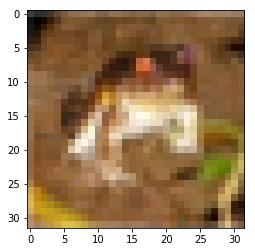

In [14]:
plt.imshow(X[0])

### Some helper functions

In [15]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    
    #The vector has a one or zero depending on the chosen image classification
    #Since there are 10 classes, out needs 10 columns 
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [16]:
class CifarHelper():
    
    '''
    Helper class to set up training images and do one-hot encoding
    The one-hot encoding provides a unique label for each image type 
    '''
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y


In [17]:
ch = CifarHelper()
ch.set_up_images()


Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [19]:
# Create placeholders for input and output nodes. Each input will be an image, whcih will be 32x32x3 since its 2D with
# 32x32 in x and y, and there are three color channels

#The output will be a 10-vector with a 1 in the slot corresponding to the desired image classification

x = tf.placeholder(tf.float32,shape=[None,32,32,3]) #images are 32x32 and there are 3 color vectors. The None in the first element means this is dictated by the batch size

#Typical shape will be [None,height,width,channels]

y_true = tf.placeholder(tf.float32,shape=[None,10]) #each y vector must contain zeros in all but 1 of its 10 slots
hold_prob = tf.placeholder(tf.float32) #placeholder for the dropout probability

In [20]:
#Here are some helper functions that might be useful when setting up the CNN

def init_weights(shape):
    
    #This is just a vector of weights to be assigned to connections in the CNN
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    
    #Vector of initial basis to be assigned to connections in the CNN. All start at 0.1
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    
    #2d convolution of an input vector x with some weights
    #Takes an input tensor and input filter kernel and produces convlution
    # x --> [batch,H,W,channels]
    # W --> [filter H, filter W, channels IN, channels OUT]
    # strides - striding in each of the directions within W. 
    # SAME means padding with zeros
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    
    #max pooling of a vector x - this reduces the amnout of information we have to deal with
    # x --> [batch,h,w,c]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    
    #Generate one convlolutional layer
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    
    #Generate one fully connected layer. Again, recall that the input size is the size of the batch that 
    #we're feeding into the CNN 
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Designing the CNN

In [21]:
#First layer - a convolutional layer. A 4x4 convolutional pooling.
#Note that 32 is the number of output channels we want - meaning the number of features for each 4x4 patch

convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [22]:
#Second layer. This is a 4x4 convolutional filtering
#This takes the output of the first layer, which is 32. We can then decide on the number of features we want to 
#select for each 4x4 patch - lets say 64 to begin with.

convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [23]:
#Flattening. Note that we have 64 features from the previous layer 
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [24]:
#DNN for the final layer, containing 1024 neurons
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [26]:
#Dropout layer
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [27]:
#Prediction layer
y_pred = normal_full_layer(full_one_dropout,10)

In [28]:
#Loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [29]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [30]:
init = tf.global_variables_initializer()

### Run the session

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
            #Note that during the testing we don't want to drop any of the neurons 
            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')